# ARIMA Forecasting JP Morgan's closing prices

## Introduction
In this project we use **ARIMA forecasting** to predict the next-day closing price of JPM. **ARIMA**, short for *'Auto Regressive Integrated Moving Average'* is a popular time series forecasting model used to predict future values based on historical data. They extend **ARMA** models by incorporating a differencing step, allowing them to handle non-stationary time series data. An ARIMA model has three components:
* **AutoRegressive (AR) Component**: Captures the relationship between an observation and a certain number of lagged observations (i.e. the previous values in the series). The order of the AR component, denoted **p**, represents the number of lagged observations considered.
* **Integrated (I) Component**: Represents differencing - differencing is performed to make the time series stationary, which means removing trends and seasonality. The order of differencing, denoted **d**, indicates the number of times differencing is applied to achieve stationarity.
* **Moving Average (MA) Component**: Represents the relationship between the error term and the lagged error terms. The order of the MA component, denoted **q**, indicates the number of lagged errors terms considered.

Below is a mathematical definition of the model, which I learned in my Time Series Analysis module at university:

<img src="defn.png" alt="Neural Net Diagram" title="3-layer neural net" width="699" height="205">

_Hopefully you can read my not-so amazing handwriting..._

### `QuantConnect`
Following the results of this project, I implemented the ARIMA forecasting into a trading strategy on QuantConnect's backtesting API. Click [here](https://james-portier.github.io/projects/arimaForecasting/arimaQC.html) to see the details


## Code
### Importing the required libraries

In [2]:
# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm # ARIMA
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test
import warnings
import yfinance as yf

### Downloading, preparing, and visualising the data
#### Timeframe
We will use data closing price data between January 1st 2013 and January 1st 2018. This specific timeframe is chosen because JPM's stock price increased relatively steadily over this period. This is suitable for this project because ARIMA models are relatively simple - they do not explicitly capture complex patterns, nonlinear relationships, or external factors that might affect stock prices. When stock prices remain stable, they often follow a smoother trend without sudden changes or large spikes, which can be more easily captured by ARIMA models.

#### Data preparation
- The data is downloaded from Yahoo Finance using the `yfinance` library, and any missing values are dropped.
- Log of the closing prices is taken. This deals with the *heteroscedasticity* present in the data, which is necessary for ARIMA models (they assume *homoscedasticity*).
    - Heteroscedasticity here means the conditional variance changes systematically over time, rather than being constant.

#### Train/test split
The data will be split into 80/20 - train/test. This is to give the model sufficient data to learn from, while also allowing us to test the model's forecasting performance on unseen data

[*********************100%***********************]  1 of 1 completed


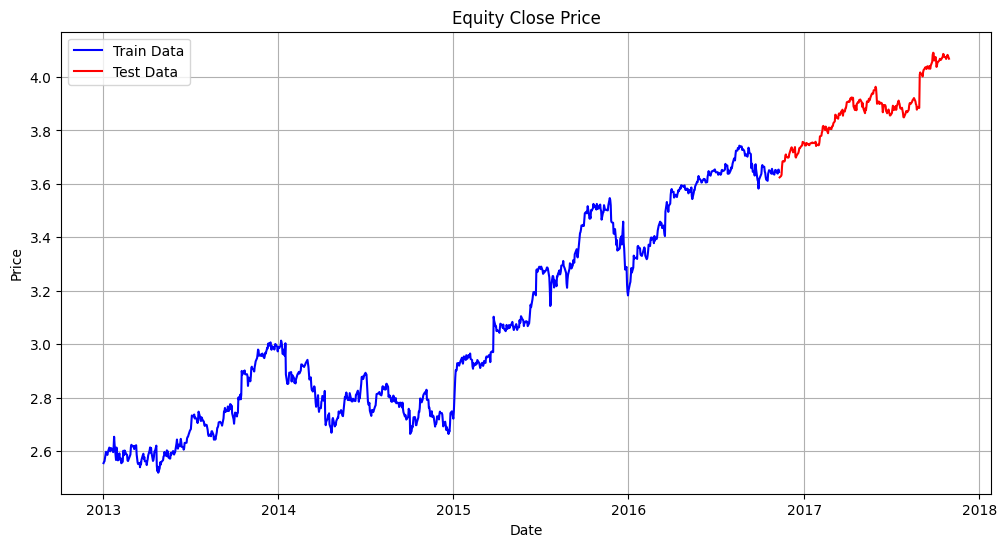

In [19]:
# Set the start and end dates for the desired time period
start_date = "2013-01-01"
end_date = "2018-01-01"

# Download JPM historical data
jpm_data = yf.download("AMZN", start=start_date, end=end_date).dropna()

# Extract the closing prices and take the log
close_prices = np.log(jpm_data["Close"])

# Assign a recognized frequency to the date index
close_prices.index = pd.date_range(start=close_prices.index[0], periods=len(close_prices), freq='B')

# split into train and test sets
size = int(len(close_prices) * 0.8) # 80/20 test/train split
train, test = close_prices[0:size], close_prices[size:len(close_prices)]

# Plotting the train and test dat5
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, color='blue', label='Train Data')
plt.plot(test.index, test, color='red', label='Test Data')
plt.title("Equity Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

### Determining the order of Differencing required
Before playing around with values for **p** and **q**, we will find a suitable value for **d** using graphical and formal tests:
* **Graphical**: Plot differenced close prices until the plot appears to be stationary (centered around mean = 0)
* **Formal**: Augmented Dicky-Fuller test

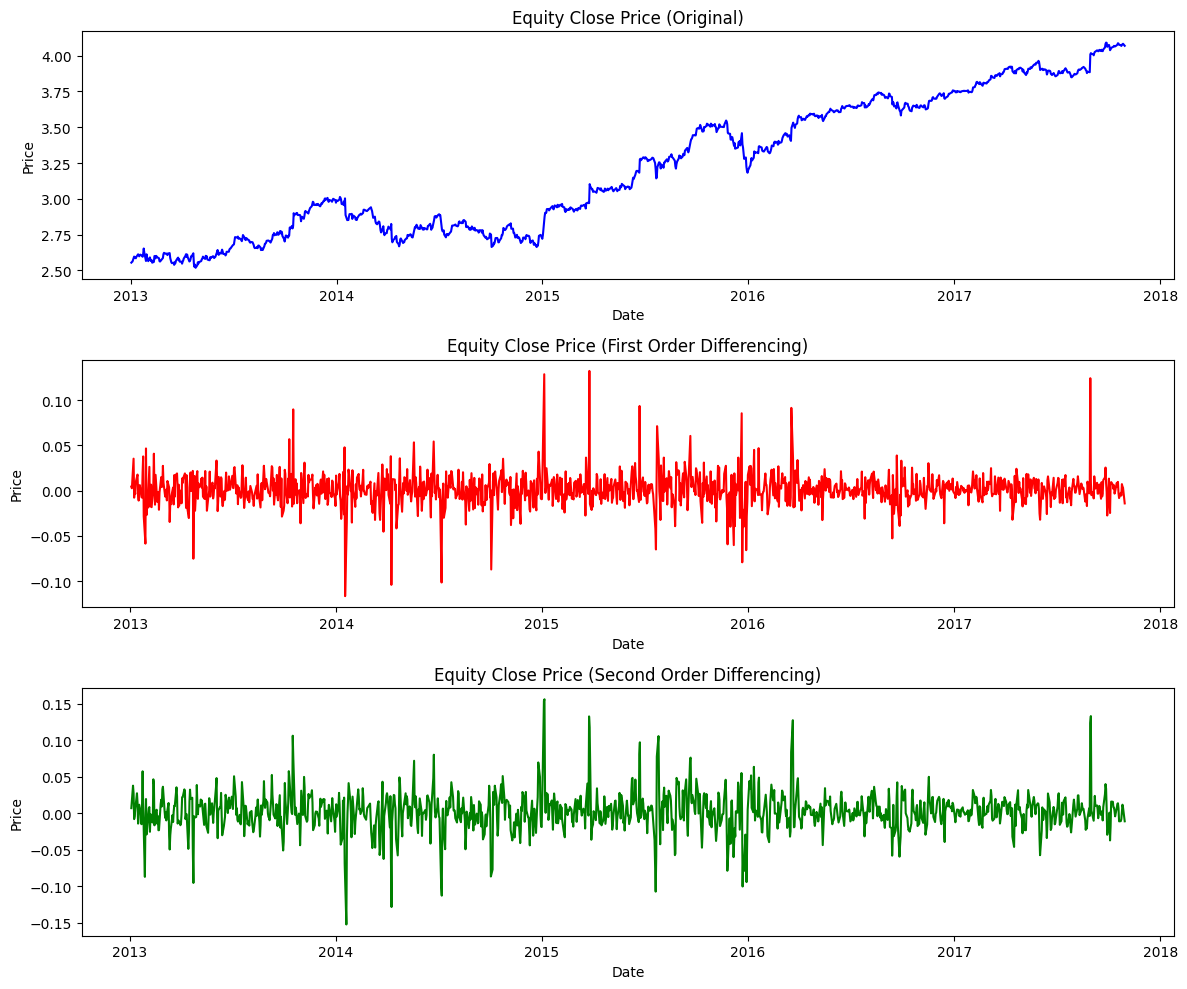

In [20]:
# First and second order differencing applied to the original time series
close_prices_diff1 = close_prices.diff(1)
close_prices_diff2 = close_prices.diff(2)

# Plot the "close" prices
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Original close prices
axes[0].plot(close_prices.index, close_prices, color='blue')
axes[0].set_title("Equity Close Price (Original)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price")

# First differenced close prices
axes[1].plot(close_prices_diff1.index, close_prices_diff1, color='red')
axes[1].set_title("Equity Close Price (First Order Differencing)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price")

# Second differenced close prices
axes[2].plot(close_prices_diff2.index, close_prices_diff2, color='green')
axes[2].set_title("Equity Close Price (Second Order Differencing)")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Price")

plt.tight_layout()
plt.show()

From the three plots above, we see that first order differencing achieves stationarity. Differencing more than this will result in an increased variance (undesirable), as seen in the third plot (note the change in y-axis range). We will therefore proceed with ARIMA(p,1,q) (d=1).

#### **Augmented Dickey-Fuller test**
Now we double check that first order differencing did in fact result in stationarity by performing the Augmented Dickey-Fuller test:
- **Null Hypothesis**: The time series is non-stationary/has a unit root
- **Alternate Hypothesis**: The time series is stationary/does not have a unit root

In [24]:
result = adfuller(close_prices.dropna())
print('p-value- no differencing: %f' % result[1])

result = adfuller(close_prices_diff1.dropna())
print('p-value - 1st ordering differencing: %f' % result[1])

p-value- no differencing: 0.939142
p-value - 1st ordering differencing: 0.000000


A p-value of 0 < 0.05 for the 1st order differencing indicates that H0 is rejected, thus confirming that 1st order differencing achieves stationarity here.

## Hyperparameter optimisation
Next, we determine optimal values for **p** and **q**, using a grid search on candidate values and comparing models by their AIC scores::

In [22]:
# Determine the optimal order for ARIMA model using AIC
best_aic = np.inf
best_order = None
d = 1

# Filter out warnings from statsmodels
warnings.filterwarnings('ignore', category=Warning, module='statsmodels')

# Manual "grid search" on candidate values for p and q 
for p in range(1,7):  
    for q in range(1,7): 
        try: # use this to handle any exceptions that may arise during fitting
            # Fit the ARIMA model with the current order p, d, q
            model = sm.tsa.ARIMA(train, order=(p, d, q))
            results = model.fit()
            aic = results.aic

            # Determine if this is the best order so far
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        except Exception as e: 
            print(e)
            continue
            
# Fit the ARIMA model with the optimal order
model = sm.tsa.ARIMA(train, order=best_order)
model_fit = model.fit()

# Get model summary
print(model_fit.summary())
print("The best order is: ", best_order)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1007
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2546.968
Date:                Wed, 05 Jul 2023   AIC                          -5083.936
Time:                        20:28:25   BIC                          -5059.368
Sample:                    01-02-2013   HQIC                         -5074.601
                         - 11-10-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4254      0.059     24.122      0.000       1.310       1.541
ar.L2         -0.9230      0.057    -16.222      0.000      -1.035      -0.812
ma.L1         -1.4261      0.067    -21.319      0.0

From the fitted model summary, we see that the optimal values for both p and q is 2. We will use these values to fit the ARIMA model to the training data.

## Forecasting next-day closing prices using `walk-forward valdation`
Now that we've optimised the hyper parameters of the ARIMA model on the training data (p=2, d=1, q=2), we can evaluate the model's prediction capabilities using the test set. We do this by making a next-day prediction for each value in the test set, refitting the ARIMA model to all historical closing prices on each iteration of the walk-forward validation.

predicted=3.644054, expected=3.624168
predicted=3.623611, expected=3.629222
predicted=3.630194, expected=3.633869
predicted=3.634222, expected=3.664138
predicted=3.664766, expected=3.683854
predicted=3.682897, expected=3.685022
predicted=3.682776, expected=3.683741
predicted=3.681812, expected=3.687654
predicted=3.686682, expected=3.705786
predicted=3.705368, expected=3.710078
predicted=3.710585, expected=3.700956
predicted=3.701544, expected=3.698186
predicted=3.698884, expected=3.700116
predicted=3.700770, expected=3.699238
predicted=3.699536, expected=3.710983
predicted=3.711337, expected=3.716543
predicted=3.716275, expected=3.733518
predicted=3.732559, expected=3.736657
predicted=3.735673, expected=3.732621
predicted=3.731921, expected=3.726151
predicted=3.725989, expected=3.717807
predicted=3.718725, expected=3.728521
predicted=3.729501, expected=3.737610
predicted=3.737942, expected=3.701549
predicted=3.701586, expected=3.698384
predicted=3.698990, expected=3.704384
predicted=3.

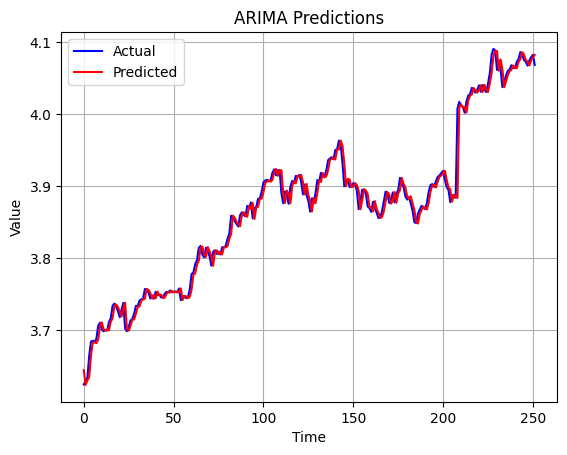

In [23]:
predictions = list()
history = [x for x in train]

# walk-forward validation
for t in range(len(test)):
    # Fit the model - use try and except to handle any exceptions that may arise during fitting
    try:
        model = sm.tsa.ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast() # forecasting one time-point ahead
        fore = output[0]
    except Exception as e:
        # If the model fails to fit, use the last predicted value
        fore = predictions[-1]
        print(e)
        continue

    predictions.append(fore)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (fore, obs))


# plot forecasts against actual outcomes
plt.plot(range(len(test)), test, label='Actual', color='blue')
plt.plot(range(len(test)), predictions, label='Predicted', color='red')
plt.title("ARIMA Predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

### Evaluating the accuracy of the predictions

In [29]:
# Counting the number of correct up/down predictions
predDiff = np.diff(predictions)
testDiff = np.diff(test)

count = 0
upCount = 0
downCount = 0
upCorrect = 0
downCorrect = 0

for x in range(len(predictions) - 1):
    # Evaluating overall accuracy
    if (predDiff[x] > 0) & (testDiff[x] > 0):
        count +=1
    elif (predDiff[x] < 0) & (testDiff[x] < 0):
        count +=1

    # Evaluating 'up' accuracy
    if (predDiff[x] > 0):
        if (testDiff[x] > 0): # correctly predicted upwards
            upCorrect +=1
            upCount +=1
        else:
            upCount +=1
            
    # Evaluating 'down' accuracy
    else:
        if (testDiff[x] < 0): # correctly predicted downwards
            downCorrect +=1
            downCount +=1
        else:
            downCount +=1

# Calculating prediction accuraccies
overallAccuracy = count/len(test)*100
upAccuracy = upCorrect/upCount*100
downAccuracy = downCorrect/downCount*100

print("The overall accuracy of the predictions is: ", overallAccuracy, "%")
print("The accuracy of the up predictions is: ", upAccuracy, "%")
print("The accuracy of the down predictions is: ", downAccuracy, "%")

The overall accuracy of the predictions is:  53.96825396825397 %
The accuracy of the up predictions is:  59.285714285714285 %
The accuracy of the down predictions is:  47.74774774774775 %


## Results
The overall accuracy of the predictions is around 54%, which is only slightly higher than random guessing (i.e. not great). An interesting result, however, is that the model is significantly more accurate at predicting upwards price movements compared to downwards price movements (59.3% vs 47.4%). This is likely due to the following reasons:
* This difference in prediction accuracy is likely influenced by the overall trend of JP Morgan's close price during the specified period
* Since JPM's closing prices exhibit a consistent upward trend from 2013 to 2018, it means that the majority of the data points in the training set were associated with upward price movements. As a result, the ARIMA model may have learned to predict upward movements more effectively because it had _more examples to learn from_.

### Limitations
There are several limitations associated with this project:
* The time frame used in this project was specifically chosen in order to be suitable for an ARIMA model. The model is not necessarily suitable for other time frames, especially those displaying large price spikes or sudden changes in trend during period of market volatility.
* In this project I train the ARIMA model on all historical data within the training timeframe. It may be favourable to make forecasts based on a rolling window of length **k**, where **k** is the number of previous days used to make the forecast. The resulting ARIMA model would be trained using only recent data, which may better represent the current market condiditions.
* It is assumed that the optimal p,q values remains the same throughout the entire test set, which may not necessarily be the case. This could be addressed by periodically updating the optimal p,q values throughout the walk-through validation.
* Taking the log of the closing prices may not have fully dealt with the heteroscedasticity/volatility clustering present in the data. 
    - To improve this project, one could combine ARIMA with another model (e.g. `GARCH`), which is specifically designed to deal with heteroscedasticity.




## Implementing the ARIMA model into a trading strategy on `QuantConnect`

Using these results, I will implement the model into QuantConnect's back testing API to see gain deeper insight into the model's performance. The trading signal for the strategy will be generated as follows:
* Train an ARIMA model on training data/for a specific warm-up period
* On each day of the testing period, predict whether the closing price will increase or decrease the next day using a next-day ARIMA forecast. If prediction is an:
    - "Up" prediction, go long. 
    - "Down" prediction, liquidate the stock.

This trading strategy capitalises on the fact that the model had better upward price prediction accuracy. Liquidating the stock, as opposed to going short in the case of a "Down" prediction, means the strategy will be less affected by the poor downward price prediction accuracy of the model, whilst making use of the strong upwards price prediction accuracy.

See my implementation of this strategy [here](https://james-portier.github.io/projects/arimaForecasting/arimaQC.html)